#Pruning Challenge



###Importing required packages

In [0]:
import tensorflow as tf 
tf.enable_eager_execution()

import os
import h5py
import numpy as np
import tempfile
import zipfile
import glob 

from shutil import move,copyfile
from numpy import linalg
from scipy.stats import rankdata

###Data Preprocessing 
In the following step I downloaded the MNIST dataset and reshaped it appropriately to obtain the training and test sets.The MNIST dataset consists of 70,000 grayscale images each 28 X 28 pixels in dimension,belonging to 10 classes and already contains a train-test split.I also normalized the pixel values and verified the final shape of the training and test matrices.

In [0]:
#loading the MNIST dataset
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()

#input image dimensions
rows, cols = 28, 28

#number of output classes
num_classes = 10

#data preprocessing
x_train = x_train.reshape(x_train.shape[0],rows*cols)
x_test = x_test.reshape(x_test.shape[0],rows*cols)
input_shape = (rows*cols, )

#normalizing the pixel valus
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape :', x_train.shape)
print(x_train.shape[0], 'training examples')
print(x_test.shape[0], 'test examples')

#converting class labels to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train,num_classes)
y_test = tf.keras.utils.to_categorical(y_test,num_classes)




11493376/11490434 [==============================] - 0s 0us/step
x_train shape : (60000, 784)
60000 training examples
10000 test examples


###Building the model
I used Keras to build the desired neural network model as shown below.It consists of 4 hidden ReLU activated layers and a final softmax layer having 10 outputs.

In [0]:
tf.reset_default_graph()

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, input_shape=input_shape),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              785000    
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2010      
Total params: 2,388,710
Trainable params: 2,388,710
Non-trainable params: 0
_________________________________________________________________


###Training and Evaluation
I trained the model for 20 epochs, using a batch size of 128.I used the **adam** optmizer and **categorical crossentropy** as the evaluation metric.
After training, I obtained the test loss and test accuracy by evaluating the model on the test set.

In [0]:
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy']
)

model.fit(x_train,y_train,
          batch_size=128,
          verbose=1,
          epochs=20,
          validation_data=(x_test,y_test))

score = model.evaluate(x_test,y_test,verbose=0)

print('Test loss :', score[0])
print('Test accuracy :', score[1])

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
60000/60000 [==============================] - 5s 83us/sample - loss: 0.2168 - acc: 0.9334 - val_loss: 0.1137 - val_acc: 0.9656
Epoch 2/20
60000/60000 [==============================] - 4s 62us/sample - loss: 0.1086 - acc: 0.9660 - val_loss: 0.1030 - val_acc: 0.9694
Epoch 3/20
60000/60000 [==============================] - 4s 64us/sample - loss: 0.0839 - acc: 0.9746 - val_loss: 0.0882 - val_acc: 0.9719
Epoch 4/20
60000/60000 [==============================] - 4s 65us/sample - loss: 0.0616 - acc: 0.9815 - val_loss: 0.0929 - val_acc: 0.9720
Epoch 5/20
60000/60000 [==============================] - 4s 63us/sample - loss: 0.0638 - acc: 0.9804 - val_loss: 0.0861 - val_acc: 0.9757
Epoch 6/20
60000/60000 [==============================] - 4s 63us/sample - loss: 0.0525 - acc: 0.9833 - val_loss: 0.0948 - val_acc: 0.9733
Epoch 7/20
60000/60000

In [0]:
#save model
_, model_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model,model_file,include_optimizer=False)


##Weight Pruning
To achieve sparsity of k% I ranked the individual weights in the weight matrix according to their magnitude (absolute value), and then set to zero the smallest k%.

In [0]:
for k in [.25, .50, .60, .70, .80, .90, .95, .97, .99]:
  copyfile(model_file,"/tmp/orig.h5")
  f=h5py.File("/tmp/orig.h5",'r+')
  ranks={}
  for a in list(f['model_weights'])[:-1]:
    info = f['model_weights'][a][a]['kernel:0']
    x = np.array(info)
    ranks[a]=(rankdata(np.abs(x),method='dense')-1).astype(int).reshape(x.shape)
    lower_bound = np.ceil(np.max(ranks[a])*k).astype(int)
    ranks[a][ranks[a]<=lower_bound] = 0
    ranks[a][ranks[a]>lower_bound] = 1
    x = x*ranks[a]
    info[...]=x
  f.close()
  move("/tmp/orig.h5","/tmp/weight_"+str(k)+".h5")

##Neuron/Unit Pruning
To achieve sparsity of k% I ranked the columns of a weight matrix according to their L2-norm and set to zero the smallest k%.

In [0]:
for k in [.25, .50, .60, .70, .80, .90, .95, .97, .99]:
  copyfile(model_file,"/tmp/orig.h5")
  f=h5py.File("/tmp/orig.h5",'r+')
  ranks={}
  for a in list(f['model_weights'])[:-1]:
    info = f['model_weights'][a][a]['kernel:0']
    x = np.array(info)
    norm = linalg.norm(x,axis=0)
    norm = np.tile(norm,(x.shape[0],1))
    ranks[a]=(rankdata(norm,method='dense')-1).astype(int).reshape(norm.shape)
    lower_bound=np.ceil(np.max(ranks[a])*k).astype(int)
    ranks[a][ranks[a]<=lower_bound] = 0
    ranks[a][ranks[a]>lower_bound] = 1
    x = x*ranks[a]
    info[...]=x
  f.close()
  move("/tmp/orig.h5","/tmp/neuron"+str(k)+".h5")
    

##Calculating accuracy for each value of sparsity 
For each value of k% sparsity,I calculted the accuracy and stored them in two lists,one for weight pruned models and the other for neuron/unit pruned models.

In [0]:
files_weights=glob.glob('/tmp/weight*.h5')
files_weights.sort()
files_neurons=glob.glob('/tmp/neuron*.h5')
files_neurons.sort()

accuracy_weights=[]
accuracy_neurons=[]

for f in files_weights:
  restored_model = tf.keras.models.load_model(f,compile=False)
  restored_model.compile(
      loss=tf.keras.losses.categorical_crossentropy,
      optimizer='adam',
      metrics=['accuracy'])
  score=restored_model.evaluate(x_test,y_test,verbose=0)
  g=h5py.File(f)
  params=0
  accuracy_weights.append(score[1])
  
for f in files_neurons:
  restored_model = tf.keras.models.load_model(f,compile=False)
  restored_model.compile(
      loss=tf.keras.losses.categorical_crossentropy,
      optimizer='adam',
      metrics=['accuracy'])
  score=restored_model.evaluate(x_test,y_test,verbose=0)
  g=h5py.File(f)
  params=0
  accuracy_neurons.append(score[1])
  
  

##Visualization

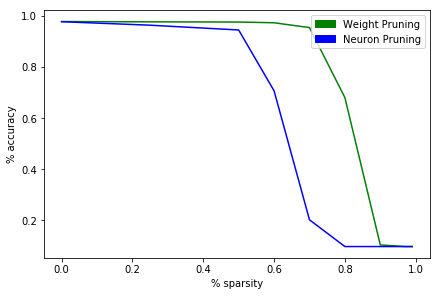

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as matpatches
plt.rcParams['figure.constrained_layout.use']=True
plt.xlabel('% sparsity')
plt.ylabel('% accuracy')
green_patch=matpatches.Patch(color='green',label='Weight Pruning')
blue_patch=matpatches.Patch(color='blue',label='Neuron Pruning')
plt.legend(handles=[green_patch,blue_patch],loc='upper right')
plt.plot([0, .25, .50, .60, .70, .80, .90, .97, .99],accuracy_weights,color='green')
plt.plot([0, .25, .50, .60, .70, .80, .90, .97, .99],accuracy_neurons,color='blue')
plt.show()

#Analysis

From the above graph we can see that the acccuracy remains largely
unchanged upto about 50% sparsity in both cases of weight as well as neuron pruning.This indicates a possibility that the baseline model is severely over-parameterized at the outset.Some of the weights(in the case of weight pruning) and neurons(in the case of neuron pruning) are redundant and capture similar information and hence their removal doesn't affect accuracy to a large extent.Also the magnitude(L1-norm in the case of weight pruning and L2-norm in the case of neuron pruning) of some of these weights or neurons is very low,and thus the changes that occur to these weights or neurons during the optimization process(i.e the gradients that are calculated during back-propagation which are used to adjust the initial weights) become insignificant as their magnitude is even lower.Thus, these weights or neurons affect the output only to a very small extent.Hence, their removal leads to only a small drop in accuracy.

A large drop in accuracy is seen at about 60% sparsity in the case of neuron pruning while in the case of weight pruning accuracy is almost constant up until 80% sparsity after which a large drop in accuracy occurs.This may be due to the fact that in the case of neuron pruning,we rank the nerons in order of their L2-norm and set to zero the smallest k%.
In some of these neurons with small L2-norms,weights capturing essential or important features might have been present, but a small L2-norm would have been obtained as a result of a majority of other weights in the neuron having low values.The probability of such a scenario increases as we increase the percentage sparsity.Weight pruning on the other hand is more targeted in the sense that it ranks individual weights and not a set of weights.Hence only those weights which are non-essential are zeroed out.Thus,a fall in accuracy occurs early(lower percentage sparsity) in the case of neuro pruning while it occurs later in the case of weight pruning.

After about 90% sparsity the accuracy of both weight pruned and neuron pruned models drops to very low values as weights or neurons capturing vital information have been set to zero.




